In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
pip install Optuna

# Water Quality Classification
#### Feature Description
* ph:물의 pH (0 ~ 14)
* Hardness: 비누 침전 용량
* solids: 총 용존 고형분(ppm)
* Chloramines: 클로로아민의 양(ppm)
* Sulfate: 용해된 황산염의 양
* Conductivity: 물의 전기 전도도(μS/cm)
* Organic_carbon: 유기 탄소의 양(ppm)
* Trihalomethanes: 트리할로메탄 양
* Turbidity: 물의 발광 특성 측정
* Potability: 물을 사람이 먹어도 안전한지 여부를 나타냄.
음용 가능하면 1, 음용불가하면 0

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import warnings
from sklearn.metrics import accuracy_score,confusion_matrix
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import optuna
from optuna import Trial,visualization
from optuna.samplers import TPESampler
#import plotly.offline as pyo
#pyo.init_notebook_mode()

In [5]:
water=pd.read_csv("/content/drive/MyDrive/Water_Quality/water_potability.csv")
water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


## EDA

##### Potability의 비율

Text(0.5, 1.0, 'Potability Ratio')

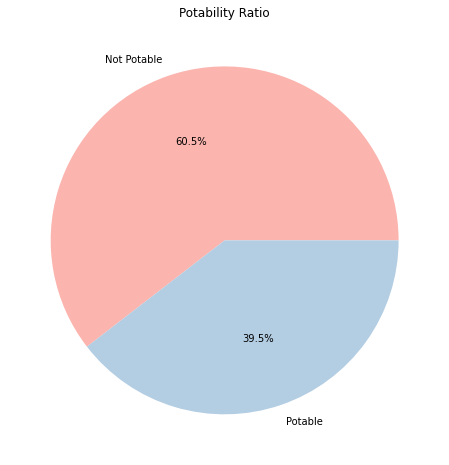

In [7]:
plt.figure(figsize=(8,8))
colors=sns.color_palette('Pastel1')
plt.pie(water.groupby('Potability')['ph'].count(),labels=['Not Potable','Potable'],
        colors=colors,autopct="%.1f%%")
plt.title("Potability Ratio")

In [8]:
water.groupby('Potability')['ph'].count()

Potability
0    1684
1    1101
Name: ph, dtype: int64

##### Target 값에 따른 Feature들의 분포

In [9]:
columns=[column for column in water.columns if column not in ['Potability']]

def create_box_plot(df,columns):
  for column in columns:
    sns.boxplot(x='Potability',y=column,data=water,palette=colors)
    plt.title(column+"-Potability")
    plt.show()

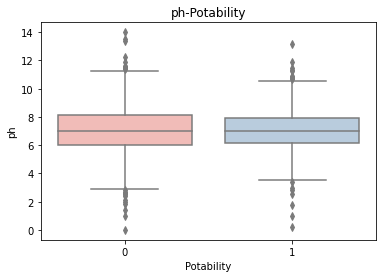

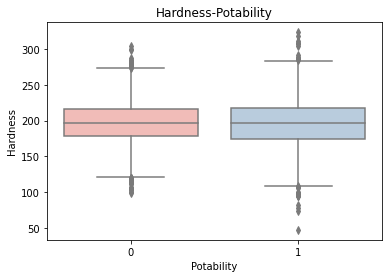

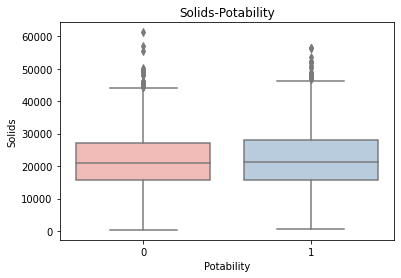

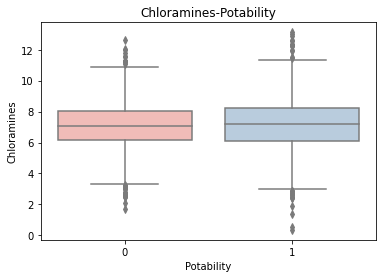

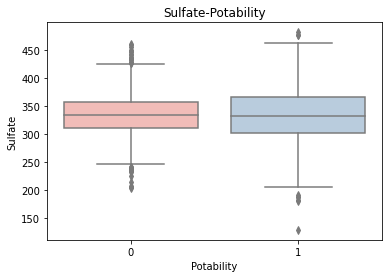

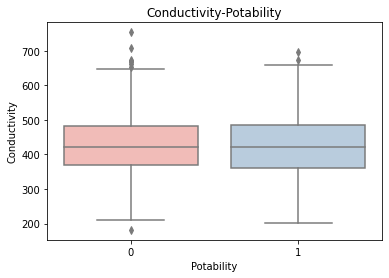

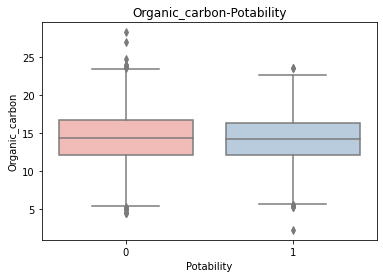

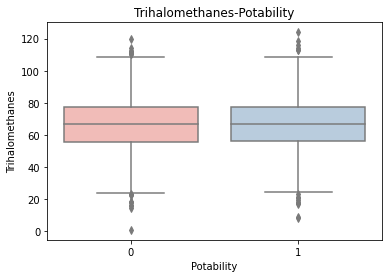

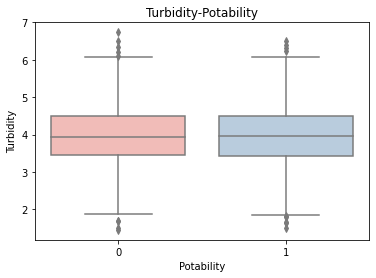

In [10]:
create_box_plot(water,columns)

##### 각 Feature들의 상관도 분석
* 각 Feature들은 크게 연관되어있지 않다.

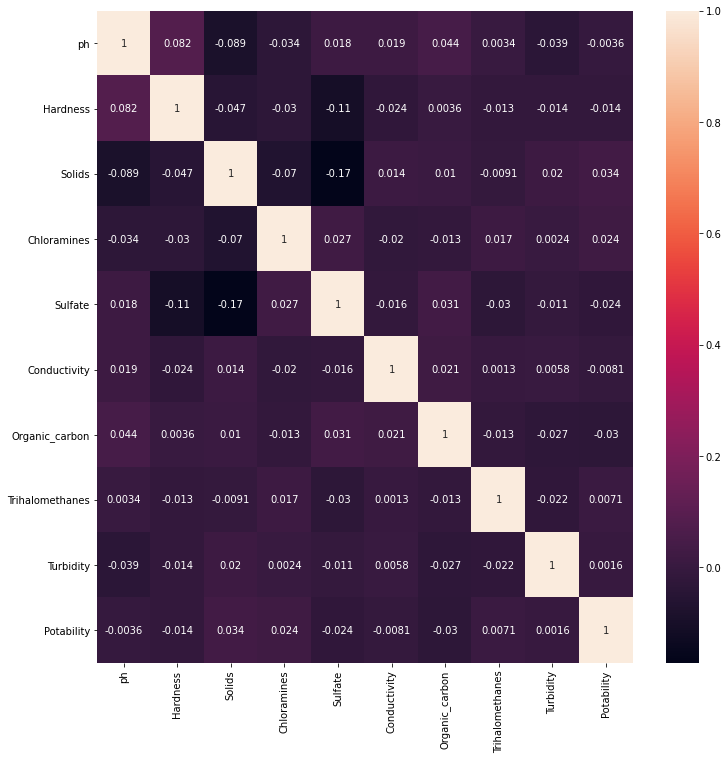

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(water.corr(),annot=True)

##### 각 Feature들의 분포 확인
* 각 Featrue들은 정규 분포를 따르고 있다.

In [12]:
def create_histogram(df,columns):
  for column in columns:
    sns.displot(df,x=column,palette=colors)
    plt.show()

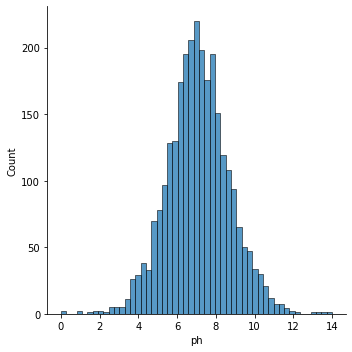

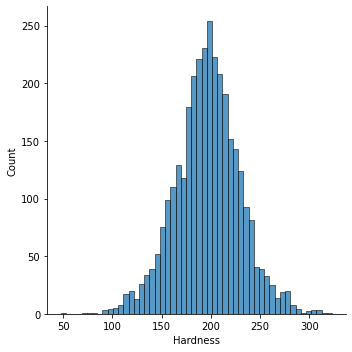

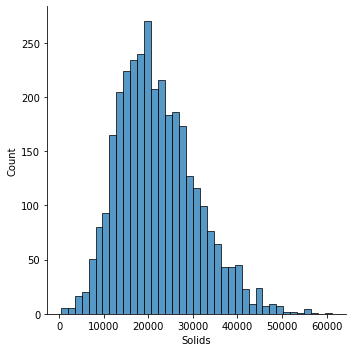

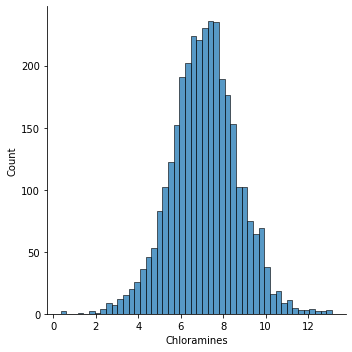

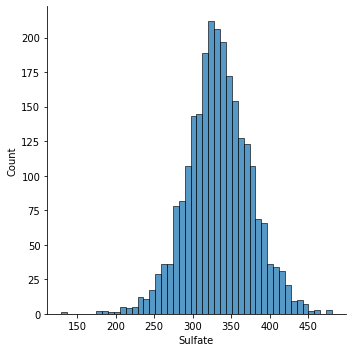

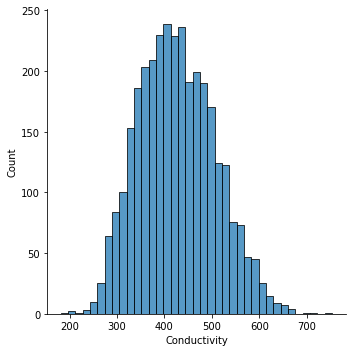

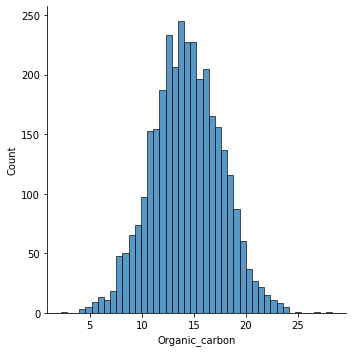

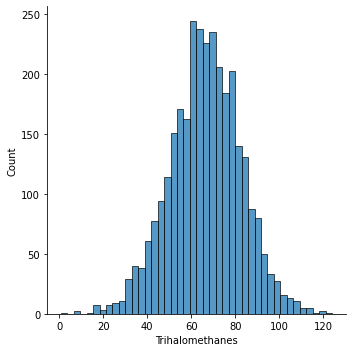

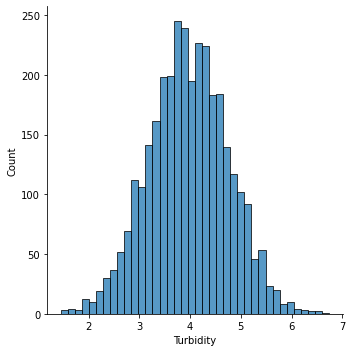

In [13]:
create_histogram(water,columns)

## 결측치 대체
1. null값 drop하기
2. 중간값으로 대체하기
3. 학습/예측으로 결측치 예측하기

이렇게 총 세가지 방법으로 결측치를 대체해 보자.

##### null값 확인
* 데이터 3276개중에, ph에서 491개, Sulfate에서 781개, Trihalomethanes에서 162개의 null값 확인

In [14]:
water.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

##### 성능을 테스트할 함수 만들기

In [15]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

params={'max_depth':[12,14,16],'n_estiamtors':[100,500,1000],'learning_rate':[0.05,0.1,0.2]}

def scoring_func(df):
  scaled_data=scaler.fit_transform(df.drop("Potability",axis=1))
  X_train,X_test,y_train,y_test=train_test_split(scaled_data,df['Potability'],test_size=0.3,
                                                 random_state=0)
  lgbm_cf=LGBMClassifier()
  grid=GridSearchCV(lgbm_cf,param_grid=params,cv=3,scoring='accuracy')
  grid.fit(X_train,y_train)
  pred=grid.predict(X_test)
  return accuracy_score(y_test,pred)

#### 1.null값 drop하기

In [16]:
scoring=[]
water_drop_null=water.dropna()
scoring.append(scoring_func(water_drop_null))

#### 2.결측치를 중간 값으로 대체하기

In [17]:
X_train,X_test,y_train,y_test=train_test_split(water.drop('Potability',axis=1),water['Potability'],test_size=0.3,
                                                 random_state=0)
imputer=SimpleImputer(strategy='median')
X_train=imputer.fit_transform(X_train)
X_test=imputer.fit_transform(X_test)
lgbm_cf=LGBMClassifier()
grid=GridSearchCV(lgbm_cf,param_grid=params,cv=3,scoring='accuracy')
grid.fit(scaler.fit_transform(X_train),y_train)
pred=grid.predict(scaler.transform(X_test))
scoring.append(accuracy_score(y_test,pred))

#### 3. 학습과 예측을 통해서 결측치를 대체해 보자

1. null값을 가지는 컬럼을 찾는다.
2. null값을 가지는 하나의 컬럼과 그 컬럼과 양의 상관관계를 가지는 다른 컬럼들을 합쳐 새로운 데이터를 만든다.
3. null값을 drop하고 ML 모델을 적용하여 학습을 한다.
4. predict하여 null값을 채운다.
5. null값이 없어질때 까지 2~4을 반복한다.

---- 
* Sulfate 칼럼의 결측치 대체를 먼저 해보자.

In [18]:
# 새로운 학습 데이터 생성
df_sul=water[['Sulfate','Organic_carbon','Chloramines']]

In [19]:
# null값 drop
df_sul=df_sul.dropna()

In [20]:
#피처들의 데이터 스케일링 진행

scaled=scaler.fit_transform(df_sul.drop('Sulfate',axis=1))

In [21]:
#학습 데이터/테스트 데이터 분리
X_train,X_test,y_train,y_test=train_test_split(scaled,
                                               df_sul['Sulfate'],
                                               test_size=0.3,
                                               random_state=42)

In [22]:
#GridSearchCV를 통해 모델의 하이퍼파라미터 튜닝
svr=SVR()
param_grid={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'degree':[1,2],
            'gamma':['scale','auto'],
            'C':[1.2,1.3,1.4,1.7]}
grid=GridSearchCV(svr,param_grid=param_grid,n_jobs=-1,cv=3,verbose=3)

In [23]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   15.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1.2, 1.3, 1.4, 1.7], 'degree': [1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [24]:
#학습과 예측을 통해 null값 추정
sulfate_filled=grid.predict(scaler.fit_transform(water[['Organic_carbon','Chloramines']]))

In [25]:
water['Sulfate']=sulfate_filled

In [26]:
water['Sulfate']

0       335.408437
1       334.885796
2       332.929631
3       335.033124
4       335.021410
           ...    
3271    334.975351
3272    335.441444
3273    335.260984
3274    334.920355
3275    334.996507
Name: Sulfate, Length: 3276, dtype: float64

---
* Trihalomethanes 칼럼의 결측치 대체 수행

In [27]:
#Trihalomethanes와 양의 상관 관계를 가진 칼럼들로 새로운 데이터 생성
df_tr=water[['Chloramines','Conductivity','Potability','Trihalomethanes']]
df_tr=df_tr.dropna()
scaled=scaler.fit_transform(df_tr.drop("Trihalomethanes",axis=1))
X_train,X_test,y_train,y_test=train_test_split(scaled,df_tr['Trihalomethanes'],
                                               test_size=0.3,random_state=42)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   22.5s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1.2, 1.3, 1.4, 1.7], 'degree': [1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [28]:
#Trihalomethanesd 결측치 예측
Trihalomethanes_filled=grid.predict(scaler.fit_transform(water[['Chloramines','Conductivity','Potability']]))

In [29]:
water['Trihalomethanes']=Trihalomethanes_filled

In [30]:
water['Trihalomethanes']

0       65.776040
1       65.547685
2       66.708051
3       66.739087
4       66.344148
          ...    
3271    65.679661
3272    66.385281
3273    66.103396
3274    66.053121
3275    66.565665
Name: Trihalomethanes, Length: 3276, dtype: float64

---
* ph컬럼 결측치 대체 수행

In [31]:
df_ph=water[['ph','Hardness','Sulfate','Conductivity','Organic_carbon','Trihalomethanes']]
df_ph=df_ph.dropna()
scaled=scaler.fit_transform(df_ph.drop('ph',axis=1))
X_train,X_test,y_train,y_test=train_test_split(scaled,df_ph['ph'],
                                               test_size=0.3,random_state=42)
grid.fit(X_train,y_train)
ph_filled=grid.predict(scaler.fit_transform(water[['Hardness','Sulfate','Conductivity','Organic_carbon','Trihalomethanes']]))
water['ph']=ph_filled
water['ph']

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   21.9s finished


0       7.073265
1       6.545875
2       7.132083
3       7.125951
4       6.909707
          ...   
3271    7.100394
3272    7.061605
3273    6.906744
3274    7.412976
3275    7.072172
Name: ph, Length: 3276, dtype: float64

* 결측치 대체 완료했으므로 결측치 확인

In [32]:
water.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

## 모델 학습 및 평가

In [33]:
scaled_data=scaler.fit_transform(water.drop('Potability',axis=1))

X_train,X_test,y_train,y_test=train_test_split(scaled_data,water['Potability'],
                                               random_state=42,test_size=0.3)


In [34]:
lgbm_cf=LGBMClassifier()
grid=GridSearchCV(lgbm_cf,param_grid=params,cv=3,scoring='accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_dept

In [35]:
pred=grid.predict(X_test)
scoring.append(accuracy_score(y_test,pred))
accuracy_score(y_test,pred)

0.9766022380467956

Text(0.5, 1.0, ' 결측치 대체 성능 비교')

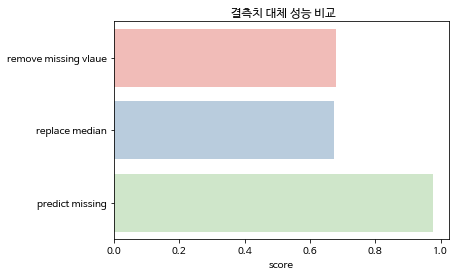

In [40]:
#세가지 방법의 score 시각화
scoring=pd.DataFrame(scoring,columns=['score'],index=['remove missing vlaue','replace median','predict missing'])
sns.barplot(data=scoring,y=scoring.index,x='score',palette=colors)
plt.title(' 결측치 대체 성능 비교')

## SMOTE을 이용한 오버샘플링

Text(0.5, 1.0, 'Target 값의 분포')

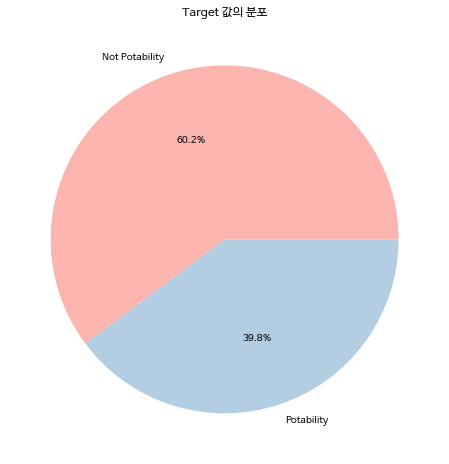

In [47]:
# 학습 데이터의 타겟값 분포
plt.figure(figsize=(8,8))
plt.pie(y_train.value_counts(),labels=['Not Potability','Potability'],colors=colors,autopct="%.1f%%")
plt.title('Target 값의 분포')

* 0이 39.5%, 1이 60.5%로 분균형한 분포를 확인할 수 있다.

이제 오버 샘플링을 해보자.

Text(0.5, 1.0, 'Target 값의 분포')

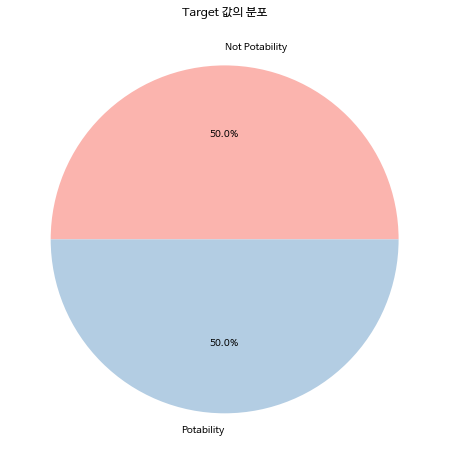

In [50]:
sm=SMOTE(random_state=0)
X_train,y_train=sm.fit_resample(X_train,y_train)
y_train=pd.Series(y_train)
plt.figure(figsize=(8,8))
plt.pie(y_train.value_counts(),labels=['Not Potability','Potability'],colors=colors,autopct="%.1f%%")
plt.title('Target 값의 분포')

* 타겟값의 분포가 균등해진것을 볼 수 있다.

In [51]:
lgbm_cf=LGBMClassifier()
grid=GridSearchCV(lgbm_cf,param_grid=params,cv=3,scoring='accuracy')
grid.fit(X_train,y_train)
pred=grid.predict(X_test)
accuracy_score(y_test,pred)

0.9806714140386572

## 모델 선택

In [53]:
rf=RandomForestClassifier()
lgb=LGBMClassifier()
xgb=XGBClassifier()
svc=SVC()

#X_train,X_test,y_train,y_test=train_test_split(scaled_data,water['Potability'],
                                              # random_state=0,test_size=0.3)

def model_selection(model):
  model.fit(X_train,y_train)
  pred=model.predict(X_test)
  return (accuracy_score(y_test,pred))

models=[rf,lgb,xgb,svc]
result=pd.DataFrame(columns=['model','score'])

for model in models:
  score=model_selection(model)
  result=result.append({'model':model.__class__.__name__,'score':score},ignore_index=True)

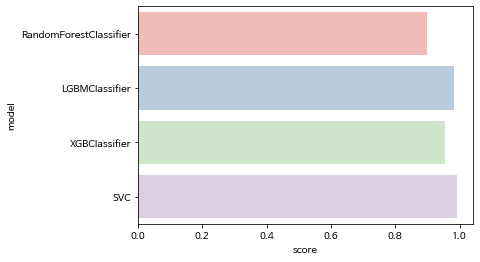

In [60]:
sns.barplot(data=result,x='score',y='model',palette=colors)

In [54]:
result

,model,score
0,RandomForestClassifier,0.898271
1,LGBMClassifier,0.982706
2,XGBClassifier,0.954222
3,SVC,0.991862


LGBMclassifier의 성능이 제일 뛰어남

## hyperparameter 튜닝

In [ ]:
def hyperparameter_tuning(trial:Trial,X_train,y_train):
  x_train_for_tuning,x_valid,y_train_for_tuning,y_valid=train_test_split(X_train,y_train,
                                                                         test_size=0.2,random_state=42)
  param={
      'n_estimators':trial.suggest_int('n_estimators',100,1000),
      'max_depth':trial.suggest_int('max_depth',12,24),
      'max_bin': trial.suggest_int('max_bin', 2, 512),
      'num_leaves': trial.suggest_int('num_leaves', 2, 512),
      'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
  }
  lgb=LGBMClassifier(**param)
  lgb.fit(x_train_for_tuning,y_train_for_tuning)
  score=accuracy_score(y_valid,lgb.predict(x_valid))

  return score

In [ ]:
study=optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial:hyperparameter_tuning(trial,X_train,y_train),n_trials=50)
print('Best trial: score {}, \ nparams {}'.format(study.best_trial,study.best_params))

In [ ]:
print(study.best_params)

In [ ]:
params=study.best_params
lgb=LGBMClassifier(**params)
lgb.fit(X_train,y_train)
pred=lgb.predict(X_test)
print('최종 accuracy score: ',accuracy_score(y_test,pred))